In [39]:
#Importamos las librerias que usaremos en este practica

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer #importar librerias de imputacion
from sklearn.preprocessing import OneHotEncoder,StandardScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline #libreria para pipelines
from sklearn.pipeline import make_pipeline 
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, f1_score

#importar libreria para leer yaml
import os
import re
import yaml

###
import pickle #Libreria para guardar modelos

#Manejo de Warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
sns.set_style('whitegrid')

In [40]:
root = re.findall('.*Taller_Practico', os.getcwd())[0]
os.chdir(root)

In [41]:
# Ruta al archivo YAML relativa al directorio encontrado
yaml_file_path = os.path.join(root, 'config.yaml')
#print(yaml_file_path)

In [42]:
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

csv_path = config['data_path']['github_csv']
df_csv = pd.read_csv(csv_path, sep=';')

parquet_path = config['data_path']['github_parquet']
df_parquet = pd.read_parquet(parquet_path)


### definicion de cual será el que se usará
df = df_parquet

In [43]:
#df_csv.info()

In [44]:
#df_parquet.info()

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3955 entries, 2987 to 898
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   GENERO                      3955 non-null   object        
 1   ESTADO_CIVIL                3955 non-null   object        
 2   FECHA_NACIMIENTO            3955 non-null   datetime64[ns]
 3   CODIGO_SEDE                 3955 non-null   object        
 4   MULTI_CANCER                337 non-null    object        
 5   CESION                      3955 non-null   object        
 6   RIESGOS                     3955 non-null   float64       
 7   CANCER_MAMA_FAMILIAR        3955 non-null   object        
 8   CANCER_OTRO_SITIO           3955 non-null   object        
 9   CANCER_OTRO_SITIO_FAMILIAR  3955 non-null   object        
 10  CEREBRAL_FAMILIAR           3955 non-null   object        
 11  FECHA_DATOS_PESO_TALLA      3955 non-null   datetime64

#### Funciones

In [46]:
def add_model(data_pipeline, model) -> Pipeline:
    whole_pipeline = Pipeline([
        ("data_pipeline", data_pipeline),
        ("model", model)
    ])
    return whole_pipeline

In [47]:
columnas_a_eliminar = ['Fecha_cero']

# Eliminar las columnas del DataFrame
df = df.drop(columnas_a_eliminar, axis=1)

df.replace('-', np.nan, inplace=True)

### Nulos

In [49]:
# Clase Transformer usando Tukey's method para deteccion y limpieza de outliers
class TukeysOutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, variable):
        self.variable = variable
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        q1 = X[self.variable].quantile(0.25)
        q3 = X[self.variable].quantile(0.75)
        iqr = q3 - q1
        inner_fence = 1.5 * iqr
        outer_fence = 3 * iqr
        
        # inner fence lower and upper end
        inner_fence_le = q1 - inner_fence
        inner_fence_ue = q3 + inner_fence
        
        # outer fence lower and upper end
        outer_fence_le = q1 - outer_fence
        outer_fence_ue = q3 + outer_fence
        
        X_outliers_removed = X[(X[self.variable] >= inner_fence_le) & (X[self.variable] <= inner_fence_ue)]
        return X_outliers_removed


In [50]:
porcetaje_de_nulidad = (
    df.isnull()
    .apply(lambda s: s.value_counts(True)).T
) 

porcetaje_de_nulidad.columns = ['not_null', 'null']
variables_muy_nulas = porcetaje_de_nulidad.query('null > 0.7').index
cant_nulos = porcetaje_de_nulidad.dropna(subset=['null'])
cant_nulos

,not_null,null
MULTI_CANCER,0.085209,0.914791
PESO,0.966372,0.033628
TALLA,0.966372,0.033628
TSISTOLICA,0.964602,0.035398
TDIASTOLICA,0.964602,0.035398


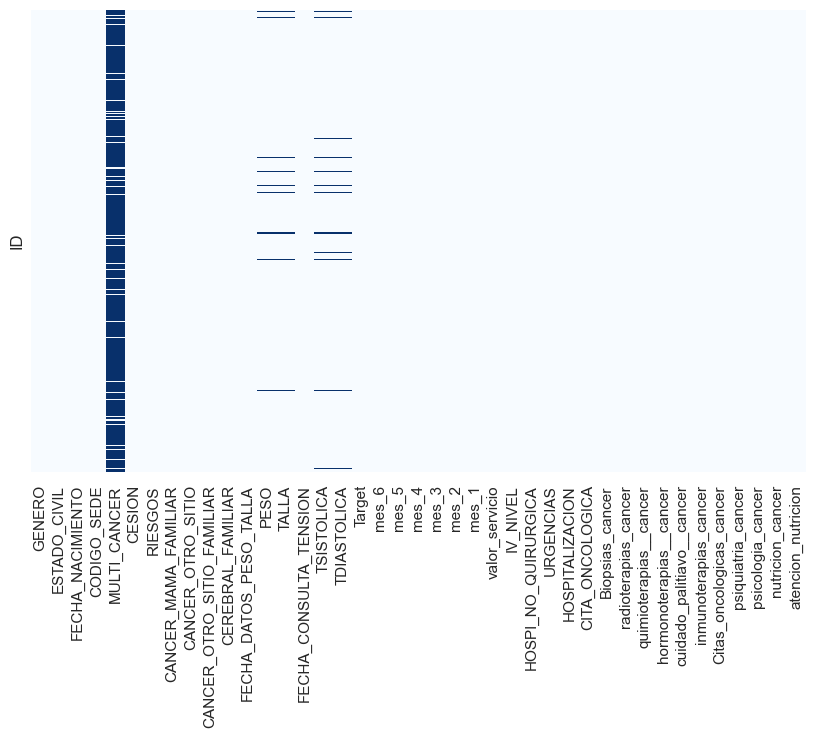

In [51]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

In [52]:
# segun definicion en sesiones de revision los nulos de MULTI_CANCER, seran rellenados con 0.
df['MULTI_CANCER'].fillna(0, inplace=True)

In [14]:
## Teniendo en cuenta la naturaleza de los datos, se decide 
#from sklearn.impute import KNNImputer

# Construimos el modelo
#imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Entrenamos el modelo
#imputer.fit(df[["TSISTOLICA"]])
#Reemplazamos los valores nulos
#df["TSISTOLICA"] = imputer.transform(df[["TSISTOLICA"]]).ravel()

#imputer.fit(df[["TDIASTOLICA"]])
#df["TDIASTOLICA"] = imputer.transform(df[["TDIASTOLICA"]]).ravel()

##### Dado que no tenemos estandarizadas las columnas, posiblemente knn no es una buea opcion

In [68]:
# Pipelines para quitar outliers
outlier_removal_pipeline = Pipeline([
    ('outlier_remover_peso', TukeysOutlierRemover(variable='PESO')),
    ('outlier_remover_talla', TukeysOutlierRemover(variable='TALLA')),
    ('outlier_remover_TSISTOLICA', TukeysOutlierRemover(variable='TSISTOLICA')),
    ('outlier_remover_TDIASTOLICA', TukeysOutlierRemover(variable='TDIASTOLICA'))
])

imputation_pipeline = Pipeline([
    ('imputer', ColumnTransformer([
        ('impute_peso', SimpleImputer(strategy='most_frequent'), ['PESO']),
        ('impute_talla', SimpleImputer(strategy='most_frequent'), ['TALLA']),
        ('impute_TSISTOLICA', SimpleImputer(strategy='median'), ['TSISTOLICA']),
        ('impute_TDIASTOLICA', SimpleImputer(strategy='median'), ['TDIASTOLICA'])
    ], remainder='passthrough'))
])

# Combinar los dos pipelines
full_pipeline = Pipeline([
    ('outlier_removal', outlier_removal_pipeline),
    ('imputation', imputation_pipeline)
])
columna_nombre =df.columns
# Aplicar el pipeline a tus datos
df_processed = full_pipeline.fit_transform(df)
#lo convertimos en df para visualizar
df_procesado = pd.DataFrame(df_processed, columns=columnas_originales.keys())

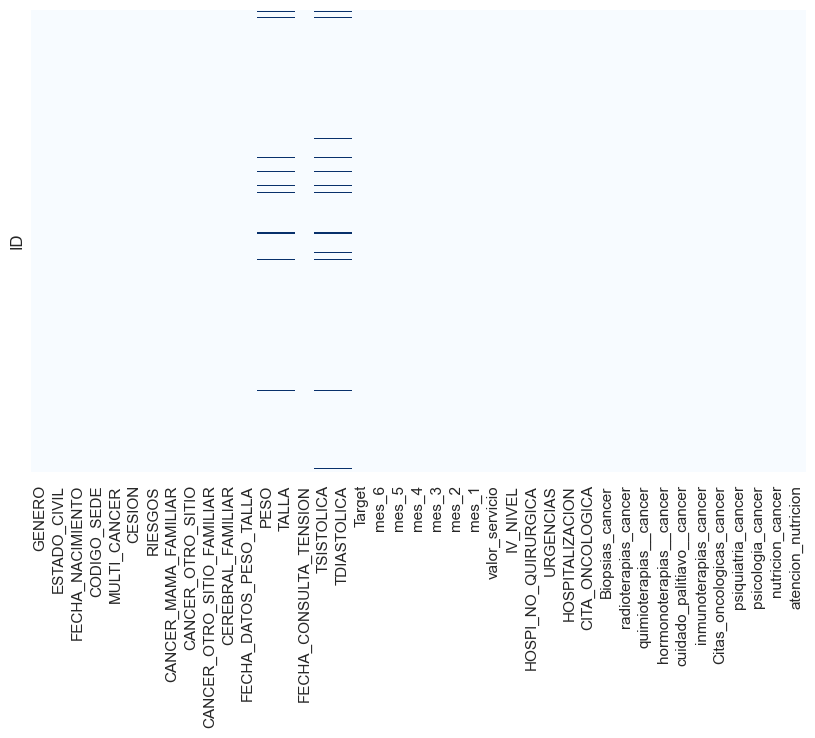

In [69]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

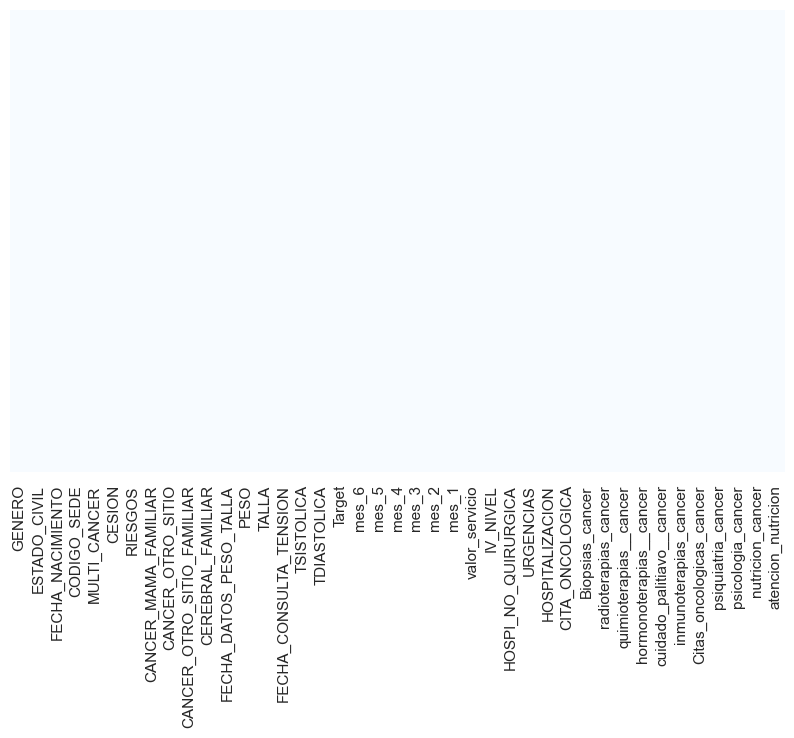

In [70]:
plt.figure(figsize=(10,6))
sns.heatmap(df_procesado.isnull(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

### Tipos

In [18]:
#df_procesado['TSISTOLICA'] = df_procesado['TSISTOLICA'].astype(float)
#df_procesado['TDIASTOLICA'] = df_procesado['TDIASTOLICA'].astype(float)

In [30]:
#columnas_numerico=['CANCER_MAMA_FAMILIAR','CANCER_OTRO_SITIO','CANCER_OTRO_SITIO_FAMILIAR','CEREBRAL_FAMILIAR']
#df_procesado[columnas_numerico] = df_procesado[columnas_numerico].astype(float)
columnas_categ= ['GENERO','ESTADO_CIVIL',#'CODIGO_SEDE',
                 'CESION','CANCER_MAMA_FAMILIAR','MULTI_CANCER',
                'CANCER_OTRO_SITIO','CANCER_OTRO_SITIO_FAMILIAR','CEREBRAL_FAMILIAR'
                ,'atencion_nutricion'
                ]
df_procesado[columnas_categ] = df_procesado[columnas_categ].astype('category')

### Guardar Parquet Transformado

In [31]:
df_procesado.to_parquet(
     config['data_path']['stage_processed'] +
    '/cancer_processed.parquet'
)

### Generacion de segundo modelo modelo para cargar

In [72]:
X, y = df_procesado.drop(columns="Target"), df_procesado["Target"]
y.value_counts(True) * 100

0.0    89.284688
1.0    10.715312
Name: Target, dtype: float64

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
print(y_train.value_counts(True)*100)
print(y_test.value_counts(True)*100)

0.0    89.188218
1.0    10.811782
Name: Target, dtype: float64
0.0    89.670014
1.0    10.329986
Name: Target, dtype: float64


In [77]:
data_pipeline = Pipeline(steps=[
    ("data_processor", full_pipeline),
    #("pca", PCA()),
])

model_kwargs = dict(
        kernel = 'rbf',
        C = 1.0,
        #probability = True
    )

pipeline = add_model(full_pipeline, LogisticRegression()) ## SVC(**model_kwargs)
pipeline 

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('outlier_removal',
                                  Pipeline(steps=[('outlier_remover_peso',
                                                   TukeysOutlierRemover(variable='PESO')),
                                                  ('outlier_remover_talla',
                                                   TukeysOutlierRemover(variable='TALLA')),
                                                  ('outlier_remover_TSISTOLICA',
                                                   TukeysOutlierRemover(variable='TSISTOLICA')),
                                                  ('outlier_remover_TDIASTOLICA',
                                                   TukeysOutlierRemover(variable='T...
                                                   ColumnTransformer(remainder='passthrough',
                                                                     transformers=[('impute_peso',
                                                                                    SimpleImputer(strategy='most_frequent'),
                                                                                    ['PESO']),
                                                                                   ('impute_talla',
                                                                                    SimpleImputer(strategy='most_frequent'),
                                                                                    ['TALLA']),
                                                                                   ('impute_TSISTOLICA',
                                                                                    SimpleImputer(strategy='median'),
                                                                                    ['TSISTOLICA']),
                                                                                   ('impute_TDIASTOLICA',
                                                                                    SimpleImputer(strategy='median'),
                                                                                    ['TDIASTOLICA'])]))]))])),
                ('model', LogisticRegression())])

In [78]:
pipeline.fit(X_train, y_train)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
with open("pipeline_2.pkl", "wb") as f:
    pickle.dump(pipeline, f)

In [ ]:
test_preds = pipeline.predict(X_test)
train_preds = pipeline.predict(X_train)
pd.DataFrame(test_preds).value_counts()
test_preds = pipeline.predict_proba(X_test)[:, 1]
train_preds = pipeline.predict_proba(X_train)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
best_th

In [ ]:
test_f1 = f1_score(y_test, test_preds>best_th)
train_f1 = f1_score(y_train, train_preds>best_th)
print(f"Train f1: {train_f1}")
print(f"Test f1: {test_f1}")


In [ ]:
plt.hist(test_preds, bins=100)
plt.show()

In [ ]:
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

parquet_path = config['data_path']['github_parquet_test']

test_df = pd.read_parquet(parquet_path)
submission_pred = pipeline.predict_proba(test_df)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred_int))
submission.to_csv("submission_2.csv", index=False)

### Generacion de primer modelo para cargar

In [ ]:
df = df.dropna(subset=["Target"])

In [ ]:
X, y = df.drop(columns="Target"), df["Target"]
y.value_counts(True) * 100

In [ ]:
columnas_numerico=['MULTI_CANCER','RIESGOS','CESION','CANCER_MAMA_FAMILIAR','CANCER_OTRO_SITIO','CANCER_OTRO_SITIO_FAMILIAR','CEREBRAL_FAMILIAR']
X[columnas_numerico] = X[columnas_numerico].astype(float)

columnas_categ= ['GENERO','ESTADO_CIVIL',#'CODIGO_SEDE',
                 'CESION','CANCER_MAMA_FAMILIAR',
                'CANCER_OTRO_SITIO','CANCER_OTRO_SITIO_FAMILIAR','CEREBRAL_FAMILIAR'
                ,'atencion_nutricion'
                ]
X[columnas_categ] = X[columnas_categ].astype(str)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
var_categoricas = ['GENERO','ESTADO_CIVIL',#'CODIGO_SEDE',
                 'CESION','CANCER_MAMA_FAMILIAR',
                'CANCER_OTRO_SITIO','CANCER_OTRO_SITIO_FAMILIAR','CEREBRAL_FAMILIAR'
                ,'atencion_nutricion'
                ]
var_numericas = X_train.select_dtypes('number').columns

In [ ]:
print(y_train.value_counts(True)*100)
print(y_test.value_counts(True)*100)

In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="if_binary")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, var_numericas),
        ("cat", categorical_transformer, var_categoricas),
    ]
)

In [ ]:
def add_model(data_pipeline, model) -> Pipeline:
    whole_pipeline = Pipeline([
        ("data_pipeline", data_pipeline),
        ("model", model)
    ])
    return whole_pipeline

data_pipeline = Pipeline(steps=[
    ("data_processor", preprocessor),
    #("pca", PCA()),
])

model_kwargs = dict(
        kernel = 'rbf',
        C = 1.0,
        #probability = True
    )

pipeline = add_model(data_pipeline, LogisticRegression()) ## SVC(**model_kwargs)
pipeline 

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
with open("pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

In [ ]:
test_preds = pipeline.predict(X_test)
train_preds = pipeline.predict(X_train)

In [ ]:
pd.DataFrame(test_preds).value_counts()

In [ ]:
test_preds = pipeline.predict_proba(X_test)[:, 1]
train_preds = pipeline.predict_proba(X_train)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
best_th

In [ ]:
test_f1 = f1_score(y_test, test_preds>best_th)
train_f1 = f1_score(y_train, train_preds>best_th)
print(f"Train f1: {train_f1}")
print(f"Test f1: {test_f1}")


In [ ]:
plt.hist(test_preds, bins=100)
plt.show()

In [ ]:
pipeline.fit(X, y)

In [ ]:
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

parquet_path = config['data_path']['github_parquet_test']

In [ ]:
test_df = pd.read_parquet(parquet_path)
submission_pred = pipeline.predict_proba(test_df)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred_int))
submission.to_csv("submission.csv", index=False)